# Model Inference

- final projects
- problem set 03
- grades update
- reading
- missing problem sets (50 percent recovery)
- Informal presentations

# Pubmed 200k: a Dataset for Sequential Sentence Classification

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

2024-04-16 14:49:36.176626: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 14:49:36.203234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 14:49:36.585181: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-e4692529-9290-4a51-cbb7-21ee9926ed7e)


## Download the data

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
from pathlib import Path
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

files = [str(x) for x in Path(data_dir).glob('*.txt')]
files

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### Preprocess the data

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir + "/train.txt")
val_lines = get_lines(data_dir + "/dev.txt")
test_lines = get_lines(data_dir + "/test.txt")

train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
def preprocess_text(data):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in data:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [9]:
# preprocess examples
train_samples = preprocess_text(train_lines)
val_samples = preprocess_text(val_lines)
test_samples = preprocess_text(test_lines)

len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [10]:
train_samples[:3]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11}]

Visualize the data in a pd dataframe

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

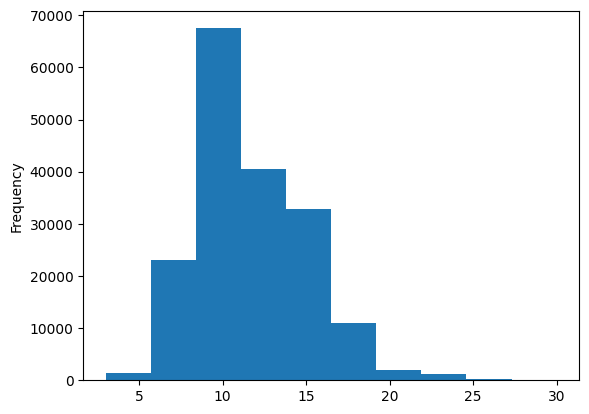

In [13]:
train_df.total_lines.plot.hist();

## Prepare data for RNN Model

### Convert to lists

In [14]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

### Create OneHotEncoding

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

train_labels_oh = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_oh = ohe.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_oh = ohe.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_oh[:5].toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

### Create classification labels

In [17]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())


train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

### Visualize class labels

In [18]:
# Get class names and number of classes from LabelEncoder instance 

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Naive Bayes Model

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded)

In [20]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

### Predictions using NB Model

In [21]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Classification report

In [93]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

# Calculate accuracy
baseline_results = accuracy_score(val_labels_encoded, baseline_preds)

report = classification_report(val_labels_encoded, baseline_preds, target_names=class_names)
print(report)

              precision    recall  f1-score   support

  BACKGROUND       0.66      0.49      0.56      3449
 CONCLUSIONS       0.65      0.59      0.61      4582
     METHODS       0.72      0.87      0.79      9964
   OBJECTIVE       0.75      0.14      0.23      2376
     RESULTS       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212



In [23]:
# Calculate precision, recall and f1 score
precision, recall, f1, _ = precision_recall_fscore_support(val_labels_encoded,
                                                           baseline_preds,
                                                           average="weighted")

precision, recall, f1

(0.7186466952323352, 0.7218323844829869, 0.6989250353450294)

## RNN Model

### Create RNN Model

### Text vectorizer

In [24]:
from tensorflow.keras.layers import TextVectorization

max_tokens = 65000
max_length = 58

vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_length)

2024-04-16 14:50:15.374375: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 14:50:15.404319: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [25]:
# Adapt text vectorizer to training sentences
vectorizer.adapt(train_sentences)

In [26]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)

print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{vectorizer([target_sentence])}")

Text:
this is a retrospective study of @ cases of ovarian torsion and @ control patients , all of whom had both us and ct performed in the emergency department .

Length of text: 30

Vectorized text:
[[  23   20    8 2106   17    4  263    4 1630 9811    3   35   12   62
     4 1030   55   54  850    3  663  153    5    2  921 1047    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [27]:
# How many words in our training vocabulary?
vocab = vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(vocab)}"), 
print(f"Most common words in the vocabulary: {vocab[:5]}")
print(f"Least common words in the vocabulary: {vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [28]:
# Get the config of our text vectorizer
vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'float32',
 'max_tokens': 65000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 58,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Embeddings

#### Sentence Embeddings

##### Create Embedding Matrix randomized (and model will learn the embeddings wrt the task)

In [29]:
# Create token embedding layer
from tensorflow.keras import layers

token_embed = layers.Embedding(input_dim=len(vocab), # length of vocabulary
                               output_dim=128,
                               mask_zero=True,
                               name="embeddings") 

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
this is a retrospective study of @ cases of ovarian torsion and @ control patients , all of whom had both us and ct performed in the emergency department .

Sentence after vectorization (before embedding):
[[  23   20    8 2106   17    4  263    4 1630 9811    3   35   12   62
     4 1030   55   54  850    3  663  153    5    2  921 1047    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]

Sentence after embedding:
[[[ 0.04389085  0.03467334 -0.04188145 ... -0.01958863  0.01231555
    0.04954857]
  [ 0.01756007 -0.02168681  0.04913134 ... -0.00662465  0.02855587
   -0.00114735]
  [ 0.02164407  0.03132576  0.03667427 ...  0.01291747  0.00704483
    0.0464263 ]
  ...
  [ 0.03206184  0.0238536  -0.0077493  ... -0.01939422  0.00949204
   -0.02469699]
  [ 0.03206184  0.0238536  -0.0077493  ... -0.01939422  0.00949204
   -0.02469699]
  [ 0.0320618

##### Use pre-trained embeddings

In [30]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [31]:
# Test out the embedding on a random sentence
rand_sent = random.choice(train_sentences)
print(f"Random training sentence:\n{rand_sent}\n")
embed_sent = hub_embedding_layer([rand_sent])
print(f"Sentence after embedding:\n{embed_sent[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(embed_sent[0])}")

Random training sentence:
each trial randomly assigned patients to doxorubicin with or without dexrazoxane .

Sentence after embedding:
[ 0.00142653 -0.07303865  0.01786812  0.06819747 -0.0042191   0.03138091
  0.01616333  0.03588602 -0.07918492 -0.01833196  0.08735595 -0.04479788
  0.0201844  -0.04325704  0.01907158 -0.00528214 -0.06801184 -0.00992442
 -0.06606583 -0.01049732  0.09425422  0.04288096 -0.05843463  0.00103131
 -0.05022738  0.00736493  0.0166608  -0.00074974 -0.00471769 -0.04030378] (truncated output)...

Length of sentence embedding:
512


2024-04-16 14:50:27.435094: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


#### Character Embeddings

In [32]:
def char_tokenizer(text):
    return " ".join(list(text))

rand_sent = random.choice(train_sentences)
print(f"Random training sentence:\n{rand_sent}\n")
print(f"Sentence after character-level tokenization:\n{char_tokenizer(rand_sent)}")

Random training sentence:
we carried out a prospective , randomized , double blind controlled trial involving @ consecutive consenting male patients admitted with diagnosis of uncomplicated alcohol withdrawal .

Sentence after character-level tokenization:
w e   c a r r i e d   o u t   a   p r o s p e c t i v e   ,   r a n d o m i z e d   ,   d o u b l e   b l i n d   c o n t r o l l e d   t r i a l   i n v o l v i n g   @   c o n s e c u t i v e   c o n s e n t i n g   m a l e   p a t i e n t s   a d m i t t e d   w i t h   d i a g n o s i s   o f   u n c o m p l i c a t e d   a l c o h o l   w i t h d r a w a l   .


In [33]:
train_chars = [char_tokenizer(sentence) for sentence in train_sentences]
val_chars = [char_tokenizer(sentence) for sentence in val_sentences]
test_chars = [char_tokenizer(sentence) for sentence in test_sentences]

In [34]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [35]:
# What's the average character length?
import numpy as np


char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

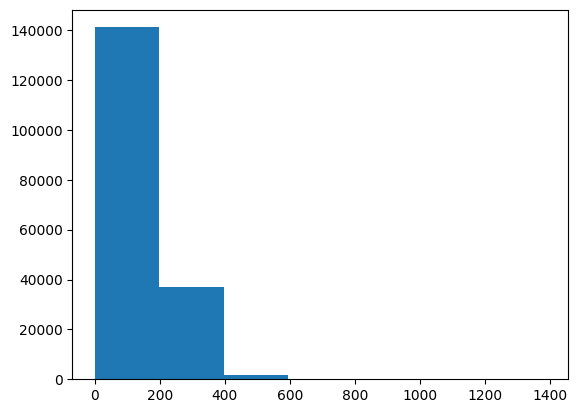

In [36]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [37]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 98))
output_seq_char_len

347

In [38]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [39]:
# Create char-level token vectorizer instance
CHAR_TOKENS_LEN = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=CHAR_TOKENS_LEN,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [40]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [41]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
b o d y   m a s s   i n d e x   w a s   @   t o   @   (   m e d i a n   ,   @   )   ,   @   (   @   %   )   p a t i e n t s   w e r e   f e m a l e   ,   a n d   a g e   w a s   @   t o   @   (   m e d i a n   ,   @   )   y e a r s   .

Length of chars: 84

Vectorized chars:
[[22  7 10 19 15  5  9  9  4  6 10  2 24 20  5  9  3  7 15  2 10  4  5  6
  14  5  3  4  2  6  3  9 20  2  8  2 17  2 15  5 12  2  5  6 10  5 18  2
  20  5  9  3  7 15  2 10  4  5  6 19  2  5  8  9  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  

In [42]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=CHAR_TOKENS_LEN, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
b o d y   m a s s   i n d e x   w a s   @   t o   @   (   m e d i a n   ,   @   )   ,   @   (   @   %   )   p a t i e n t s   w e r e   f e m a l e   ,   a n d   a g e   w a s   @   t o   @   (   m e d i a n   ,   @   )   y e a r s   .

Embedded chars (after vectorization and embedding):
[[[ 0.01859853 -0.0345783   0.00077229 ... -0.04318703 -0.0171136
    0.00598603]
  [ 0.01461972 -0.02416627 -0.02575722 ...  0.03336455 -0.03596988
    0.02219368]
  [ 0.04808379  0.02135707  0.02623174 ...  0.04449796 -0.00669463
   -0.00156119]
  ...
  [-0.01535947  0.04142033 -0.01793446 ...  0.01592301  0.0244392
   -0.01785703]
  [-0.01535947  0.04142033 -0.01793446 ...  0.01592301  0.0244392
   -0.01785703]
  [-0.01535947  0.04142033 -0.01793446 ...  0.01592301  0.0244392
   -0.01785703]]]

Character embedding shape: (1, 347, 25)


#### Line position embeddings

In [43]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

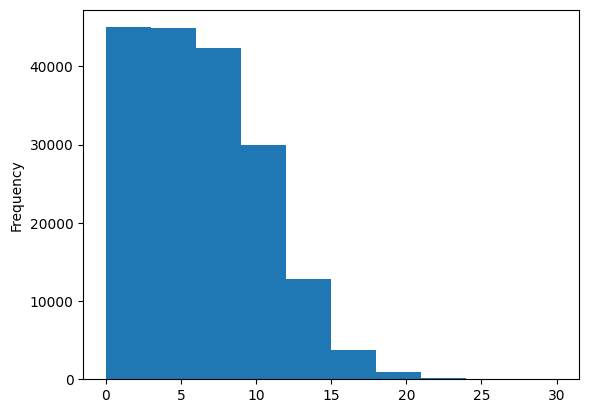

In [44]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [45]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_oh = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_oh = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_oh = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [46]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_oh.shape, train_line_numbers_oh[:10]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

In [60]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_oh = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_oh = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_oh = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

print(f"train_line_numbers_oh shape: {train_line_numbers_oh.shape}")
print(f"val_line_numbers_oh shape: {val_line_numbers_oh.shape}")

train_line_numbers_oh shape: (180040, 15)
val_line_numbers_oh shape: (30212, 15)


#### Total lines embeddings

In [57]:
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

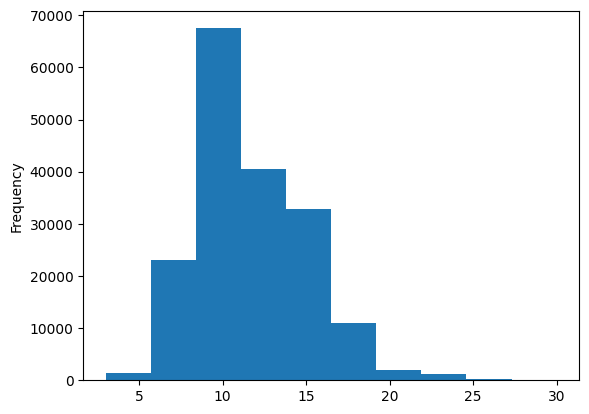

In [58]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [62]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_oh = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_oh = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_oh = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

print(f"train_total_lines_oh shape: {train_total_lines_oh.shape}")
print(f"val_total_lines_oh shape: {val_total_lines_oh.shape}")

# Check shape and samples of total lines one-hot tensor
train_total_lines_oh.shape, train_total_lines_oh[:10]

train_total_lines_oh shape: (180040, 20)
val_total_lines_oh shape: (30212, 20)


(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Combine the embeddings

Configure our inputs

In [63]:

class MyLayer(layers.Layer):
    def call(self, inputs):
        return hub_embedding_layer(inputs)
    
# Token inputs
tokens = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = MyLayer(name='Sentence_Embedding')(tokens)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=tokens,
                             outputs=token_outputs)

# Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

Concatenate the embeddings

In [94]:
# Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

### Define our model

In [95]:
model = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [65]:
# Get a summary of our token, char and positional embedding model
model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_inputs         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_inputs        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 347)       │          0 │ char_inputs[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sentence_Embedding  │ (None, 512)       │          0 │ token_inputs[0][… │
│ (MyLayer)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 347, 25)   │      1,750 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     65,664 │ Sentence_Embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     14,848 │ char_embed[2][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid_… │ (None, 192)       │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_input   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │     49,408 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_positio… │ (None, 320)       │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ dense_10[0][0],   │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ token_char_posit… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 134,459 (525.23 KB)

 Trainable params: 134,459 (525.23 KB)

 Non-trainable params: 0 (0.00 B)

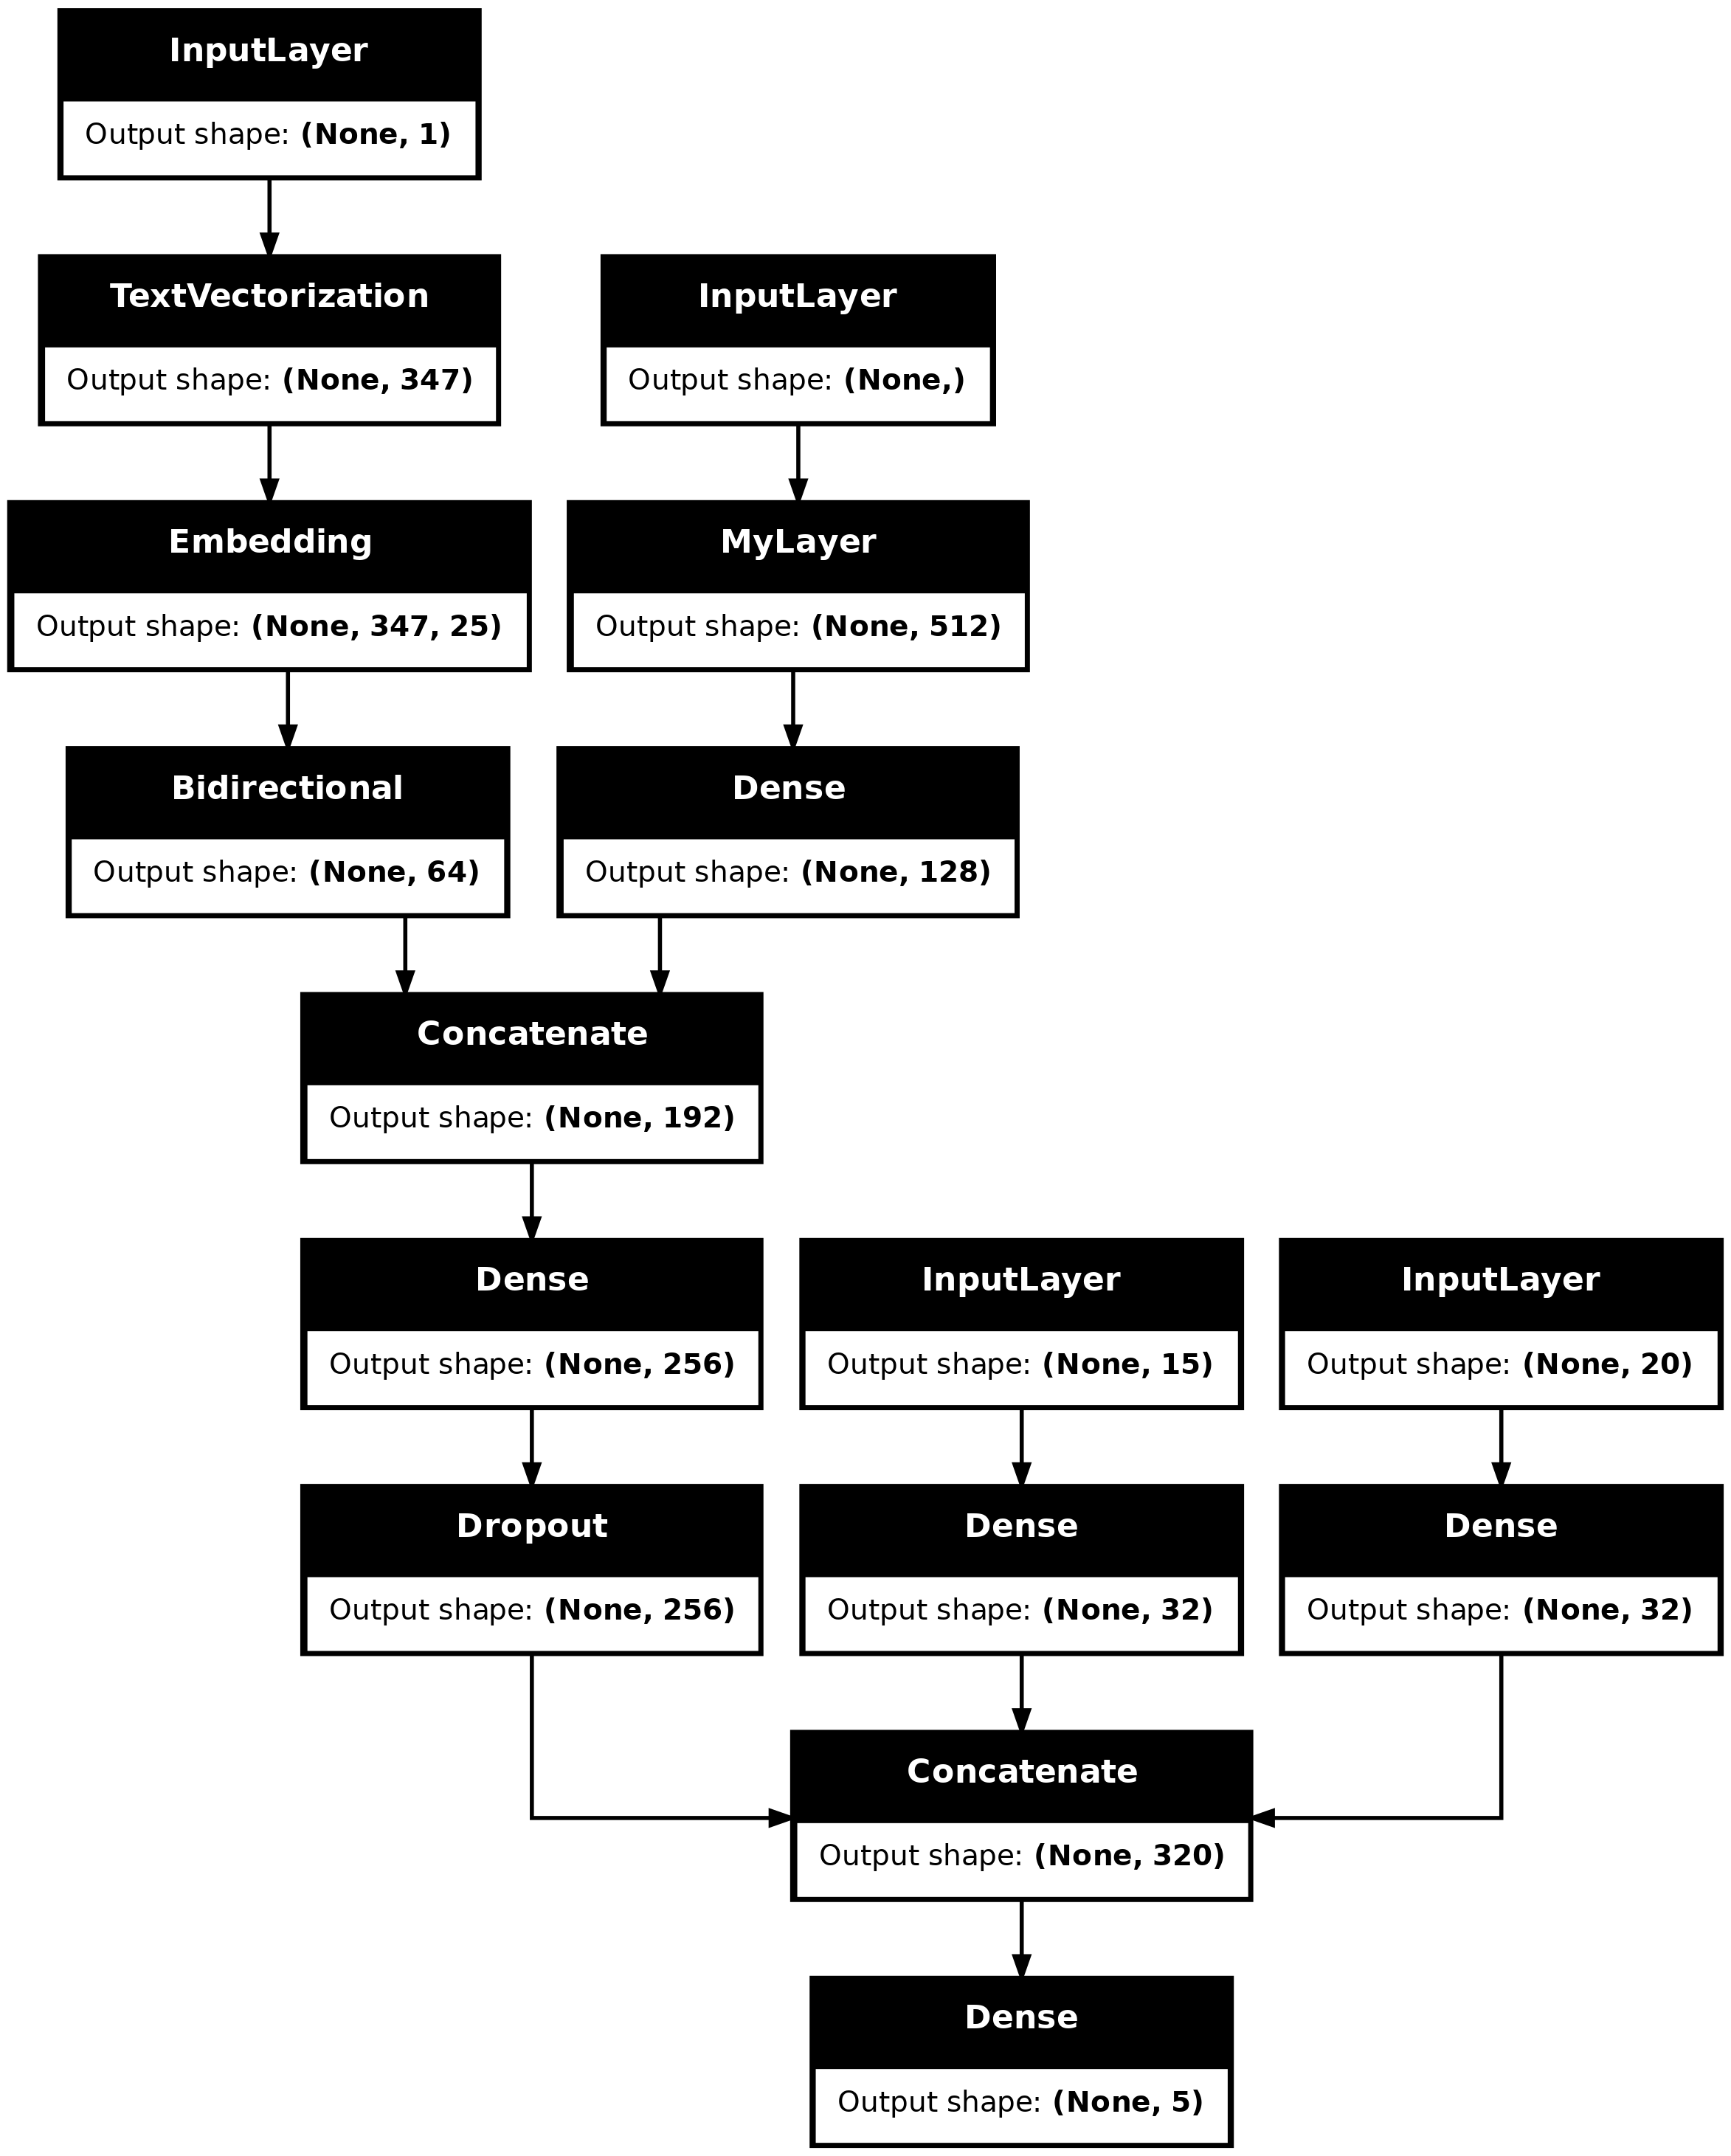

In [66]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [52]:
for layer in model.layers:
    print(layer, layer.trainable)

<InputLayer name=char_inputs, built=True> True
<InputLayer name=token_inputs, built=True> True
<TextVectorization name=char_vectorizer, built=True> True
<MyLayer name=my_layer, built=True> True
<Embedding name=char_embed, built=True> True
<Dense name=dense, built=True> True
<Bidirectional name=bidirectional, built=True> True
<Concatenate name=token_char_hybrid_embedding, built=True> True
<InputLayer name=line_number_input, built=True> True
<InputLayer name=total_lines_input, built=True> True
<Dense name=dense_3, built=True> True
<Dense name=dense_1, built=True> True
<Dense name=dense_2, built=True> True
<Dropout name=dropout, built=True> True
<Concatenate name=token_char_positional_embedding, built=True> True
<Dense name=output_layer, built=True> True


### Train our model

In [67]:
# Compile token, char, positional embedding model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [84]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_oh, # line numbers
                                                                train_total_lines_oh, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars))
# Convert sparse matrix to dense numpy array
train_labels_oh_dense = train_labels_oh.toarray()   

# Create dataset
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_oh_dense) # train labels

train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

In [86]:
# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_oh,
                                                              val_total_lines_oh,
                                                              val_sentences,
                                                              val_chars))
val_labels_oh_dense = val_labels_oh.toarray()

val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_oh_dense)

val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

In [87]:
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [88]:
# Fit the token, char and positional embedding model
history_model = model.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.6265 - loss: 1.2269 - val_accuracy: 0.8019 - val_loss: 0.9861
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.8081 - loss: 0.9762 - val_accuracy: 0.8248 - val_loss: 0.9449
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.8184 - loss: 0.9575 - val_accuracy: 0.8281 - val_loss: 0.9373


### Make predictions with our Model

In [89]:
predictions = model.predict(val_pos_char_token_dataset, verbose=1)
predictions

945/945 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step


array([[0.4742293 , 0.12157378, 0.01268133, 0.36797523, 0.02354033],
       [0.5370403 , 0.10526985, 0.04443579, 0.30414692, 0.0091072 ],
       [0.3066865 , 0.11945116, 0.14518532, 0.35645556, 0.07222141],
       ...,
       [0.04372156, 0.11166153, 0.04572435, 0.03769912, 0.7611934 ],
       [0.03008619, 0.30133656, 0.07929666, 0.02606169, 0.5632189 ],
       [0.25062737, 0.5158587 , 0.12196612, 0.04504891, 0.06649885]],
      dtype=float32)

In [91]:
# look at the most incorrect predictions
preds_df = pd.DataFrame(predictions)
preds_df.columns = class_names
preds_df["target"] = val_df["target"]



In [92]:
preds_df

,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,target
0,0.474229,0.121574,0.012681,0.367975,0.023540,BACKGROUND
1,0.537040,0.105270,0.044436,0.304147,0.009107,BACKGROUND
2,0.306686,0.119451,0.145185,0.356456,0.072221,OBJECTIVE
3,0.043207,0.078850,0.695646,0.041680,0.140615,METHODS
4,0.061975,0.064786,0.627093,0.056315,0.189830,METHODS
...,...,...,...,...,...,...
30207,0.058804,0.104461,0.058923,0.044542,0.733269,RESULTS
30208,0.029816,0.113846,0.084669,0.035242,0.736427,RESULTS
30209,0.043722,0.111662,0.045724,0.037699,0.761193,RESULTS
30210,0.030086,0.301337,0.079297,0.026062,0.563219,CONCLUSIONS
